# Season Dataset (Version 1)
This will be the simlest version of our season dataset in which the label or the task is to tell the season from a given month in the Northern semisphere.

For simplicity, we assume the following:

- Spring: March, April, May
- Summer: June, July, August
- Autumn: September, October, November
- Winter: December, January, February


In [1]:
import numpy as np

In [2]:
JAN = 1
FEB = 2
MAR = 3
APR = 4
MAY = 5
JUN = 6
JUL = 7
AUG = 8
SEP = 9
OCT = 10
NOV = 11
DEC = 12

SEED = 20

In [3]:
X = np.arange(JAN, DEC+1)
season_to_id = {
    "spring": 0,
    "summer": 1,
    "autumn": 2,
    "winter": 3,
}

def make_labels(months):
    labels = np.empty_like(months)
    for i, month in enumerate(months):
        if MAR <= month <= MAY:
            labels[i] = season_to_id["spring"]
        elif JUN <= month <= AUG:
            labels[i] = season_to_id["summer"]
        elif SEP <= month <= NOV:
            labels[i] = season_to_id["autumn"]
        else:
            labels[i] = season_to_id["winter"]
    return labels

y = make_labels(X)
y

array([3, 3, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3])

## First Dataset, First Model

Due to its simplicity, our train/val/test sets will be really small, compared to what we usually see in a usual dataset.

Besides, for the moment we just take this raw data and apply ML/NN models to see how well they may perform.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4/12, random_state=SEED)
X_train.shape, X_test.shape

((8,), (4,))

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [7]:
log_clf = LogisticRegression()
svm_clf = SVC(probability=True)
rnd_clf = RandomForestClassifier()

In [8]:
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("svm", svm_clf), ("rf", rnd_clf)],
    voting="soft",
)

In [9]:
X = X.reshape((-1, 1))
#y = y.reshape((-1, 1))
X.shape, y.shape

((12, 1), (12,))

In [10]:
X_train = X_train.reshape((-1, 1))
#y_train = y_train.reshape((-1, 1))
X_train.shape, y_train.shape

((8, 1), (8,))

In [11]:
X_test = X_test.reshape((-1, 1))
#y_test = y_test.reshape((-1, 1))
X_test.shape, y_test.shape

((4, 1), (4,))

**N.B.** So, note this:
> Fitting a voting classifier won't automatically fit the models it includes inside it.

In [12]:
voting_clf.fit(X_train, y_train)
for clf in (log_clf, svm_clf, rnd_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="micro")
    recall = recall_score(y_test, y_pred, average="micro")
    print(f"({clf.__class__.__name__}) acc = {acc:.2f}, precision = {precision:.2f}, recall = {recall:.2f}")

(LogisticRegression) acc = 0.25, precision = 0.25, recall = 0.25
(SVC) acc = 0.25, precision = 0.25, recall = 0.25
(RandomForestClassifier) acc = 0.75, precision = 0.75, recall = 0.75
(VotingClassifier) acc = 0.50, precision = 0.50, recall = 0.50


In [13]:
print(f"X_test.reshape(-1) = {X_test.reshape(-1)}")
print(f"y_test = {y_test}")
for clf in (log_clf, svm_clf, rnd_clf, voting_clf):
    y_pred = clf.predict(X_test)
    print(f"\n({clf.__class__.__name__})")
    print(f"y_pred = {y_pred}")

X_test.reshape(-1) = [8 2 9 6]
y_test = [1 3 2 1]

(LogisticRegression)
y_pred = [3 0 2 0]

(SVC)
y_pred = [2 0 2 0]

(RandomForestClassifier)
y_pred = [1 3 2 0]

(VotingClassifier)
y_pred = [1 0 2 0]


## Second Dataset, Same Models
Let's standardize the features and then just apply the same model to see if things will get better.

In [14]:
X_train

array([[ 1],
       [ 3],
       [ 7],
       [12],
       [ 5],
       [10],
       [11],
       [ 4]])

In [15]:
X_test

array([[8],
       [2],
       [9],
       [6]])

In [16]:
X_train_stand = X_train / DEC
X_test_stand = X_test / DEC
X_train_stand

array([[0.08333333],
       [0.25      ],
       [0.58333333],
       [1.        ],
       [0.41666667],
       [0.83333333],
       [0.91666667],
       [0.33333333]])

In [17]:
for clf in (log_clf, svm_clf, rnd_clf, voting_clf):
    clf.fit(X_train_stand, y_train)
    y_pred = clf.predict(X_test_stand)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="micro")
    recall = recall_score(y_test, y_pred, average="micro")
    print(f"({clf.__class__.__name__}) acc = {acc:.2f}, precision = {precision:.2f}, recall = {recall:.2f}")

(LogisticRegression) acc = 0.00, precision = 0.00, recall = 0.00
(SVC) acc = 0.25, precision = 0.25, recall = 0.25
(RandomForestClassifier) acc = 0.75, precision = 0.75, recall = 0.75
(VotingClassifier) acc = 0.50, precision = 0.50, recall = 0.50


> The situation after standardization is **not getting better**.

**(?)** How come `acc, precision, recall` all have the same value for each classifier? Did you do it wrong or sth?

## Third Dataset, Same Models
Use sine and cosine to try to make the points more separable. This is actually more like increasing the number of features to increase the possibility to separate the data points geometrically!

In [18]:
def sinusoid(X_batch):
    """
    args
        theta, float
            DEC gives 2pi and JAN gives 2pi / 12
    """
    theta = 2 * np.pi * (X_batch / DEC)
    return np.c_[np.cos(theta), np.sin(theta)]

In [19]:
X_train

array([[ 1],
       [ 3],
       [ 7],
       [12],
       [ 5],
       [10],
       [11],
       [ 4]])

In [20]:
X_train_sinusoid = sinusoid(X_train)
X_train_sinusoid

array([[ 8.66025404e-01,  5.00000000e-01],
       [ 6.12323400e-17,  1.00000000e+00],
       [-8.66025404e-01, -5.00000000e-01],
       [ 1.00000000e+00, -2.44929360e-16],
       [-8.66025404e-01,  5.00000000e-01],
       [ 5.00000000e-01, -8.66025404e-01],
       [ 8.66025404e-01, -5.00000000e-01],
       [-5.00000000e-01,  8.66025404e-01]])

In [21]:
import matplotlib.pyplot as plt

In [30]:
[s for s in plt.rcParams.keys() if "color" in s]

['axes.edgecolor',
 'axes.facecolor',
 'axes.labelcolor',
 'axes.titlecolor',
 'boxplot.boxprops.color',
 'boxplot.capprops.color',
 'boxplot.flierprops.color',
 'boxplot.flierprops.markeredgecolor',
 'boxplot.flierprops.markerfacecolor',
 'boxplot.meanprops.color',
 'boxplot.meanprops.markeredgecolor',
 'boxplot.meanprops.markerfacecolor',
 'boxplot.medianprops.color',
 'boxplot.whiskerprops.color',
 'figure.edgecolor',
 'figure.facecolor',
 'grid.color',
 'hatch.color',
 'legend.edgecolor',
 'legend.facecolor',
 'lines.color',
 'lines.markeredgecolor',
 'lines.markerfacecolor',
 'mpl_toolkits.legacy_colorbar',
 'patch.edgecolor',
 'patch.facecolor',
 'patch.force_edgecolor',
 'pcolor.shading',
 'pdf.inheritcolor',
 'savefig.edgecolor',
 'savefig.facecolor',
 'scatter.edgecolors',
 'text.color',
 'xtick.color',
 'ytick.color']

In [22]:
DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "white",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

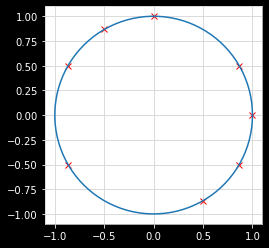

In [23]:
plt.plot(X_train_sinusoid[:, 0], X_train_sinusoid[:, 1], "rx");
t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(t), np.sin(t))
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True);

In [24]:
X_test_sinusoid = sinusoid(X_test)
X_test_sinusoid

array([[-5.00000000e-01, -8.66025404e-01],
       [ 5.00000000e-01,  8.66025404e-01],
       [-1.83697020e-16, -1.00000000e+00],
       [-1.00000000e+00,  1.22464680e-16]])

In [27]:
for clf in (log_clf, svm_clf, rnd_clf, voting_clf):
    clf.fit(X_train_sinusoid, y_train)
    y_pred = clf.predict(X_test_sinusoid)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="micro")
    recall = recall_score(y_test, y_pred, average="micro")
    print(f"({clf.__class__.__name__})\nacc = {acc:.2f}, precision = {precision:.2f}, recall = {recall:.2f}\n")

(LogisticRegression)
acc = 0.25, precision = 0.25, recall = 0.25

(SVC)
acc = 0.50, precision = 0.50, recall = 0.50

(RandomForestClassifier)
acc = 0.50, precision = 0.50, recall = 0.50

(VotingClassifier)
acc = 0.25, precision = 0.25, recall = 0.25



## Maybe...
There are just too little data for this to make sense. Too little data to do ML, maybe.

This is actually funny: I thought this was going to be the easiest among the notebooks I was going to create, the models' performance all really good, etc. etc. But quite the contrary.